In [1]:
# Import modules
import os
import datetime
from IPython.display import display
import math
import re


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import scipy
import scipy.stats

from utilities import *
import hedge_functions

# Master simulation source file

## Read Data

In [2]:
# Setup utilities and and data path
datadir = os.path.join('..', 'data')

In [3]:
## Select data to analyze
files = ['isx2008C.xls', 'isx2010C.xls']
filename = os.path.join(datadir, files[1])

# Read all sheets into a dictonary with sheet names as keys
data = pd.read_excel(filename, sheet_name=None)

In [4]:
sheet_names = list(data.keys())
sheet_name = 'isx15012010C'

sheet, (mat, T, S, Cobs, E, r) = get_sheet(data, sheet_name)
n,m = Cobs.shape

In [5]:
## Simulation utilities

%matplotlib inline 

def get_closest_strike(estimate, strikes):
    """
    Return the strike price closest to given estimate
    """
    return strikes[(np.abs(strikes - estimate)).argmin()]
    

## Simple Delta Simulation

In [6]:
def simple_delta_simulation(sheet, strikes, step=1, mat=45, diff=0, sigma=0.1):
    """
    Simulate hedging for estimated costs accuracy of hedging
    
    Params:
        sheet (pd.DataFrame): worksheet to hedge
        strikes (pd.Series):  strike prices for convinience
        step (int):           number of days between hedges
        maturity (int):       number of days to maturity when starting hedging
        diff (int):           difference between spot and strike prices
                              = 0 for ATM-option
                              < 0 for out-of-the-money option
                              > 0 for in-the-money option
    Returns:
        errors (pd.Series)
        MSE (float)
        costs (float)
    """
    
    
    spot = sheet.s_price.iloc[0]          # spot price on t0
    
    # Construct a single option portfolio with one option
    # C1 and hedge it with delta amount of underlying
    
    strike = get_closest_strike(spot + diff, strikes) # select C1 strike
    
    portfolio = sheet.rename(columns={
        strike: 'C1'
    })[['C1', 's_price', 'time', 'r']]
    
    # Include only 'mat' preceeding days
    portfolio = portfolio[portfolio.index <= mat]
    
    # Select days to rehedge
    hedge_rows = portfolio.iloc[::step, :]
    
    def call_hedge(row):
        """
        Helper function to apply on all rows row by row
        """
        # Calculate implied volatility
        sigma = hedge_functions.calculate_implied_volatility_bs(
            row.time, strike, row.s_price, row.r, row.C1)
        # Calculate delta
        return hedge_functions.delta_hedge(row.time, strike, row.s_price, row.r, sigma)

    # Calculate deltas for given days
    delta = hedge_rows.apply(call_hedge, axis=1)
    
    # Keep deltas constant between rehedge days
    portfolio['delta'] = delta.reindex(portfolio.index).fillna(method='ffill')
    
    # Calculate change of value of single option portfolio 
    portfolio['dC1'] = (portfolio.C1 - portfolio.C1.shift(1))
    
    # Calculate value and change of value of the replicating portfolio
    portfolio['Re'] = portfolio.delta/100 * portfolio.s_price
    portfolio['dRe'] = portfolio.Re - portfolio.Re.shift(1)
    
    # Calculate error as diffrence between change of value of the
    # replicating portfolio and the option portfolio
    portfolio['A'] = portfolio.dRe - portfolio.dC1
    
    # Calculate the change of delta. This is used for estimating
    # turnover ratio and transaction costs
    portfolio['dDelta'] = delta - delta.shift(1)
    
    return portfolio

# portfolio = simple_delta_simulation(sheet, E, step=2)
# portfolio

,MSE_atm,MSE_itm,MSE_otm,turnover_atm,turnover_itm,turnover_otm
0,0.018333,0.016585,0.017966,0.778547,0.779428,0.521868
1,0.017653,0.015938,0.017488,0.475212,0.466159,0.311553
2,0.017659,0.015915,0.017426,0.270364,0.282296,0.212182
3,0.017628,0.015019,0.016402,0.289820,0.235314,0.196792
4,0.017511,0.014598,0.015698,0.172874,0.175947,0.131621
5,0.017605,0.014527,0.015501,0.154623,0.169204,0.137538


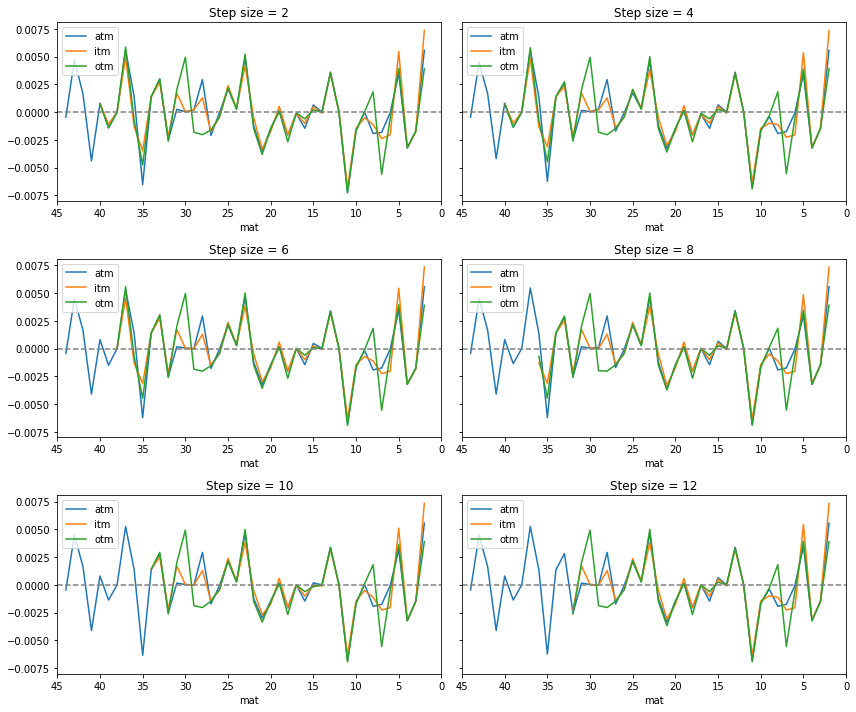

In [7]:

# Select three options to perform simple delta hedging on.
# One at-the-money, one slighlty in-the-money and one slightly 
# of-the-money option

diffs = [0, 0.006, -0.006] # how much to differiate option from spot price
labels = ['atm', 'itm', 'otm']

 # Keep these paramters fixed for all three options
hedge_freq = [2, 4, 6, 8, 10, 12]
num_sim = len(hedge_freq)
mat = 45

# Initalize matrices to store simulation results
MSE = np.zeros((num_sim, 3))
turnover = np.zeros((num_sim, 3))

# Plot results
fig, axes = plt.subplots(math.ceil(num_sim / 2),2,figsize=(12,10), sharey=True)

for i, (ax, freq) in enumerate(zip(axes.flat, hedge_freq)):
    for j, (diff, label) in enumerate(zip(diffs,labels)):
        
        df = simple_delta_simulation(sheet, E, step=freq, diff=diff, mat=mat)
        df.plot(y='A', ax=ax, label=label)
        
        MSE[i, j] = np.sqrt(df.A.pow(2).sum())
        turnover[i, j] = df.dDelta.abs().sum()
    
    ax.axhline(y=0, linestyle='dashed', color='grey')
    ax.set_xlim([mat, 0]) 
    ax.set_title('Step size = {}'.format(freq))
    
    
fig.tight_layout()
    
MSE_df = pd.DataFrame(MSE, columns = ["MSE_{}".format(label) for label in labels])
turnover_df = pd.DataFrame(turnover,  columns=["turnover_{}".format(label) for label in labels])

stats = pd.concat([MSE_df, turnover_df], axis=1)

#stats['costs'] = stats.Turnover* 1e5*5e-4

display(stats)

## Simple Delta-Vega Simulation

In [8]:
def simple_delta_vega_simulation(sheet, strikes, step=1, mat1=45, tdiff=15, pdiff=0, sigma=0.1):
    """
    Simulate hedging for estimated costs accuracy of hedging
    
    Params:
        sheet (pd.DataFrame): worksheet to hedge
        strikes (pd.Series):  strike prices for convinience
        step (int):           number of days between hedges
        mat1 (int):           number of days to maturity when starting hedging
        tdiff (int):          mat2 = mat1 + tdiff
        pdiff (int):          difference between spot and strike prices
                              = 0 for ATM-option
                              < 0 for out-of-the-money option
                              > 0 for in-the-money option
    Returns:
        errors (pd.Series)
        MSE (float)
        costs (float)
    """
    
    spot = sheet.s_price.iloc[0]       # spot price on t0
    
    
    # Construct a single option portfolio with one option
    # C1 and hedge it with delta amount of underlying
    
    
    # Construct a portfolio with two options on same underlying,
    # same strike but with different maturities. Call option with
    # shorter maturity C1 and the latter C2
    
    strike = get_closest_strike(spot + pdiff, strikes) 

    portfolio = sheet.rename(columns={
        strike: 'C1',
        'time': 'mat1'
    })
    portfolio['C2'] = portfolio.C1.shift(tdiff)
    portfolio['mat2'] = portfolio.mat1.shift(tdiff)
    
    # For convinience select only columns we're interested in
    portfolio = portfolio[['C1', 'C2', 'mat1', 'mat2', 'r', 's_price']]
    
    # Select only information preceeding mat1 days from maturity of C1
    portfolio = portfolio[portfolio.index <= mat1] 
    
    # Call rehedge on given time steps only
    hedge_rows = portfolio.iloc[::step, :]
    
    def call_hedge(row):
        """
        Helper function to apply on all selected rows
        """
        # Calculate implied volatility
        sigma = hedge_functions.calculate_implied_volatility_bs(
            row.mat1, strike, row.s_price, row.r, row.C1)
        
        # Calculate alpha and eta
        alpha, eta = hedge_functions.vega_hedge(
            row.mat1, row.mat2, strike, row.s_price, row.r, sigma)
        return pd.Series({'alpha': alpha, 'eta': eta})
    
    # Calculate alpha and eta parameters
    hedge_rows = pd.concat([hedge_rows, hedge_rows.apply(call_hedge, axis=1)], axis=1)
    
    # Fill constant alpha and eta between rehedge days
    portfolio = hedge_rows.reindex(index=portfolio.index).fillna(method='ffill')
    
    # Calculate change of value for portfolio consiating of only C1
    portfolio['dC1'] = portfolio.C1 - portfolio.C1.shift(1)
    
    # Calculate value and change of value for replicating portfolio
    portfolio['Re'] = portfolio.alpha/100 * portfolio.s_price + portfolio.eta/100 * portfolio.C2
    portfolio['dRe'] = portfolio.Re - portfolio.Re.shift(1)
    
    # Calculate error as diffrence between change of value of the
    # replicating portfolio and the option portfolio
    portfolio['A'] = portfolio.dRe - portfolio.dC1
    
    # Estimate transaction costs by calculating turnover of C2 and underlying
    portfolio['dAlpha'] = portfolio.alpha - portfolio.alpha.shift(1)
    portfolio['dEta'] = portfolio.eta - portfolio.eta.shift(1)
    
    return portfolio


,MSE_atm,MSE_itm,MSE_otm,t_alpha_atm,t_alpha_itm,t_alpha_otm,t_eta_atm,t_eta_itm,t_eta_otm
0,0.016978,0.012577,0.013928,0.945890,0.924626,0.841056,0.798223,0.765087,0.762347
1,0.012189,0.010271,0.010802,0.627705,0.576420,0.566633,0.570996,0.528881,0.553069
2,0.011107,0.009461,0.009937,0.699899,0.662450,0.664861,0.692458,0.654120,0.659664
3,0.012840,0.009860,0.010378,0.545532,0.530209,0.550200,0.551685,0.524343,0.546274
4,0.009354,0.007421,0.008344,0.545532,0.490427,0.509277,0.551685,0.495926,0.512708
5,0.011862,0.010122,0.010819,0.433663,0.378395,0.405060,0.433939,0.371244,0.399412


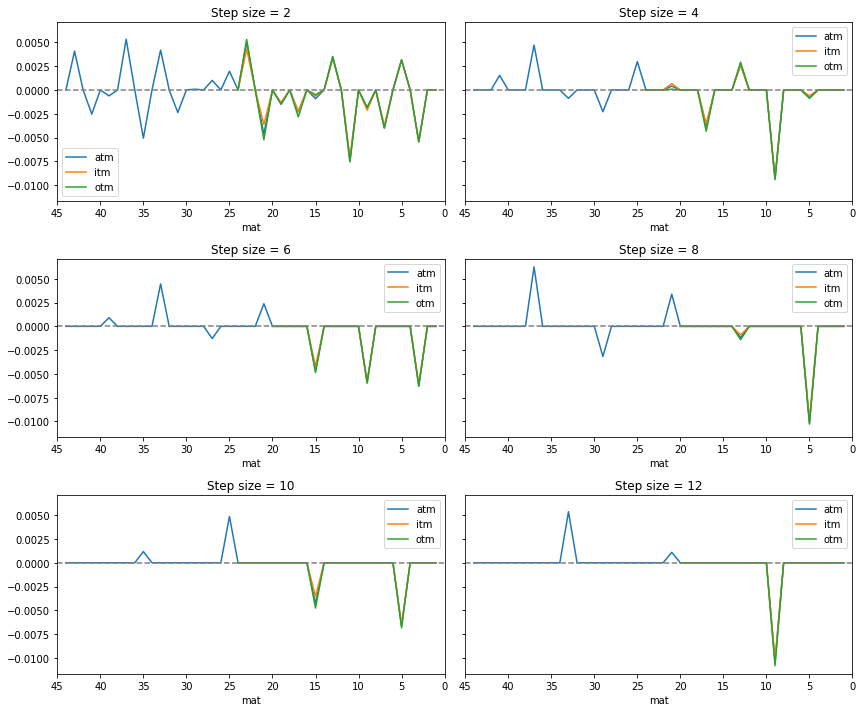

In [9]:
# Select three options to perform simple delta hedging on.
# One at-the-money, one slighlty in-the-money and one slightly 
# of-the-money option

diffs = [0, 0.006, -0.006] # how much to differiate option from spot price
labels = ['atm', 'itm', 'otm']

# Keep these paramters fixed for all three options
hedge_freq = [2, 4, 6, 8, 10, 12]
num_sim = len(hedge_freq)
mat1 = 45

# Initalize matrices to store simulation results
MSE = np.zeros((num_sim, 3))
turnover_alpha = np.zeros((num_sim, 3))
turnover_eta = np.zeros((num_sim, 3))

fig, axes = plt.subplots(math.ceil(num_sim / 2),2,figsize=(12,10), sharey=True)

for i, (ax, freq) in enumerate(zip(axes.flat, hedge_freq)):
    for j, (diff, label) in enumerate(zip(diffs,labels)):
        
        df = simple_delta_vega_simulation(sheet, E, step=freq, pdiff=diff, mat1=mat1)
        df.plot(y='A', ax=ax, label=label)
        
        MSE[i, j] = np.sqrt(df.A.pow(2).sum())
        turnover_alpha[i,j] = df.dAlpha.abs().sum()
        turnover_eta[i,j] = df.dEta.abs().sum()
        
    ax.axhline(y=0, linestyle='dashed', color='grey')
    ax.set_xlim([mat, 0]) 
    ax.set_title('Step size = {}'.format(freq))

fig.tight_layout()

MSE_df = pd.DataFrame(MSE, columns = ["MSE_{}".format(label) for label in labels])
turnover_alpha_df = pd.DataFrame(turnover_alpha,  columns=["t_alpha_{}".format(label) for label in labels])
turnover_eta_df = pd.DataFrame(turnover_eta,  columns=["t_eta_{}".format(label) for label in labels])

stats = pd.concat([MSE_df, turnover_alpha_df, turnover_eta_df], axis=1)
#stats['costs'] = stats.Turnover* 1e5*5e-4

display(stats)


## Butterfly Delta Simulation

In [10]:
def butterfly_delta_simulation(sheet, strikes, step=1, mat=45, diff=0):
    """
    Simulate hedging for estimated costs accuracy of hedging
    
    Params:
        sheet (pd.DataFrame): worksheet to hedge
        strikes (pd.Series):  strike prices for convinience
        step (int):           number of days between hedges
        maturity (int):       number of days to maturity when starting hedging
        diff (int):           difference between spot and strike prices
                              = 0 for ATM-option
                              < 0 for out-of-the-money option
                              > 0 for in-the-money option
    Returns:
        errors (pd.Series)
        MSE (float)
        costs (float)
    """
    
    spot = sheet.s_price.iloc[0]                    # spot price at t0
    
    atm = get_closest_strike(spot, strikes)         # atm strike at t0
    itm = get_closest_strike(spot + 0.1, strikes)   # option with higher strike
    otm = get_closest_strike(spot - 0.1, strikes)   # option with lower strike
    
    # Construct portfolio of only the selected three options
    portfolio = sheet.rename(columns={
        atm: 'C_atm',
        otm: 'C_otm',
        itm: 'C_itm'
    })[['C_atm', 'C_itm', 'C_otm', 's_price', 'r', 'time']]
    
    
    # Store strike prices for calculating delta
    strikes = [itm, otm, atm]
    
    # Include price data only from 'mat' last days 
    portfolio = portfolio[portfolio.index <= mat]
    
    # Select days to perform rehedge
    hedge_rows = portfolio.iloc[::step, :] # select days to rehedge
        
    def call_hedge(row):
        """
        Helper function to apply on all rows
        """
        # Calculate implied volatility of C_atm
        sigma = hedge_functions.calculate_implied_volatility_bs(
            row.time, atm, row.s_price, row.r, row.C_atm)
        # Calculate delta for portfolio
        return hedge_functions.delta_hedge_butterfly(row.time, strikes, row.s_price, row.r, sigma)
        
    # Calculate deltas for portfolio
    delta = hedge_rows.apply(call_hedge, axis=1)
    
    # Fill constant deltas for portfolio between rehedge days
    portfolio['delta'] = delta.reindex(portfolio.index).fillna(method='ffill')
    
    # Calculate value and change of value for portfolio of options
    portfolio['V'] = portfolio.C_itm - 2*portfolio.C_atm + portfolio.C_otm
    portfolio['dV'] = portfolio.V - portfolio.V.shift(1)
    
    # Calculate value and change of value for replicating portfolio
    portfolio['Re'] = portfolio.delta/100 * portfolio.s_price
    portfolio['dRe'] = portfolio.Re - portfolio.Re.shift(1)
    
    # Calculate error as diffrence between change of value of the
    # replicating portfolio and the option portfolio
    portfolio['A'] = portfolio.dRe - portfolio.dV
    
    # Calculate change of delta for portfolio. This is used in estimating
    # turnover rate and transaction costs
    portfolio['dDelta'] = delta - delta.shift(1)
    
    return portfolio


,Hedge Freq,MSE,Turnover,costs
0,2,0.017666,1.028708,51.435377
1,4,0.018344,0.386905,19.345253
2,6,0.018378,0.271855,13.592738
3,8,0.018498,0.275068,13.753392
4,10,0.018502,0.214365,10.718253
5,12,0.018383,0.212842,10.642098


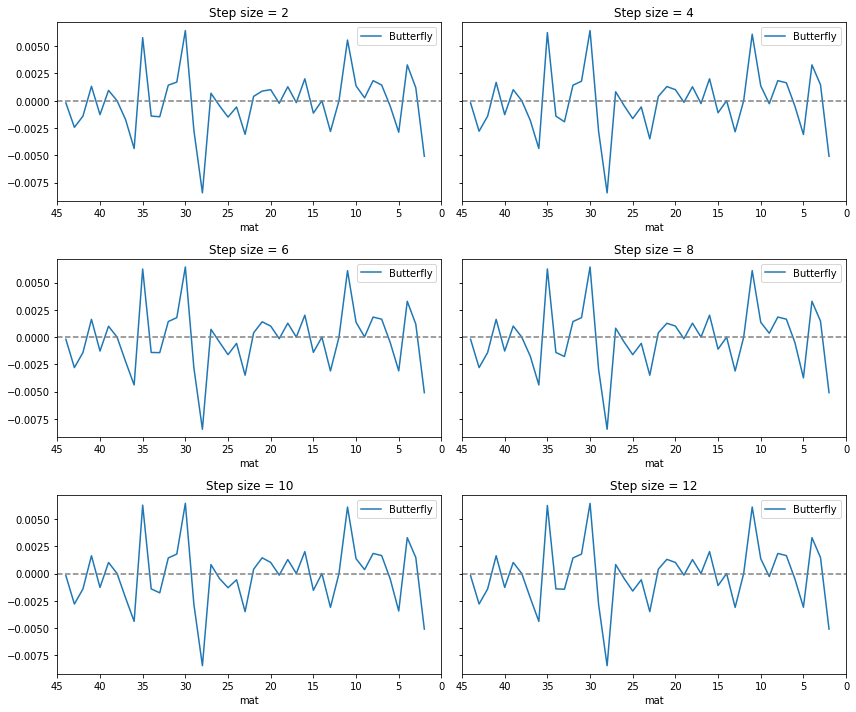

In [11]:

hedge_freq = [2, 4, 6, 8, 10, 12]
num_sim = len(hedge_freq)
mat = 45
fig, axes = plt.subplots(math.ceil(num_sim / 2),2,figsize=(12,10), sharey=True)

MSE = np.zeros(num_sim)
turnover = np.zeros(num_sim)

for i, (ax, freq) in enumerate(zip(axes.flat, hedge_freq)):
    
    df = butterfly_delta_simulation(sheet, E, step=freq, diff=0, mat=mat)
    df.plot(y='A', ax=ax, label='Butterfly')
    
    ax.axhline(y=0, linestyle='dashed', color='grey')
    ax.set_xlim([mat, 0]) 
    ax.set_title('Step size = {}'.format(freq))
    
    MSE[i] = np.sqrt(df.A.pow(2).sum())
    turnover[i] = df.dDelta.abs().sum()

fig.tight_layout()
    
stats = pd.DataFrame({
    'MSE': MSE,
    'Turnover': turnover,
    'Hedge Freq': hedge_freq
    })

stats['costs'] = stats.Turnover* 1e5*5e-4

display(stats)

## Butterfly Delta-Vega Simulation

In [12]:
def butterfly_delta_vega_simulation(sheet, strikes, step=1, mat1=45, pdiff=0, tdiff=15):
    """
    Simulate hedging for estimated costs accuracy of hedging
    
    Params:
        sheet (pd.DataFrame): worksheet to hedge
        strikes (pd.Series):  strike prices for convinience
        step (int):           number of days between hedges
        mat1 (int):           number of days to maturity when starting hedging
        tdiff (int):          mat2 = mat1 + tdiff
        
    Returns:
        errors (pd.Series)
        MSE (float)
        costs (float)
    """
    
    spot = sheet.s_price.iloc[0]                    # spot price at t0
    
    atm = get_closest_strike(spot, strikes)         # atm strike at t0
    itm = get_closest_strike(spot + 0.1, strikes)   # option with higher strike
    otm = get_closest_strike(spot - 0.1, strikes)   # option with lower strike
    
    # Construct portfolio of three options with different strikes
    portfolio = sheet.rename(columns={
        atm: 'C1_atm',
        otm: 'C1_otm',
        itm: 'C1_itm',
        'time': 'T1'
    })[['C1_atm', 'C1_itm', 'C1_otm', 's_price', 'r', 'T1']]
    
    # Hedge with underlying and three options with selected strikes but
    # with longer maturity. We'll refer to these as C2_name
    
    portfolio['C2_atm'] = portfolio.C1_atm.shift(tdiff)
    portfolio['C2_itm'] = portfolio.C1_itm.shift(tdiff)
    portfolio['C2_otm'] = portfolio.C1_otm.shift(tdiff)
    
    # Store maturity of longer options
    portfolio['T2'] = portfolio.T1.shift(tdiff)
    
    # Store strike prices of options for calculating delta
    strikes = [itm, otm, atm]
    
    # Include price data only from 'mat1' last days 
    portfolio = portfolio[portfolio.index <= mat1]
    
    # Select days to perform rehedge
    hedge_rows = portfolio.iloc[::step, :] # select days to rehedge
        
    def call_hedge(row):
        """
        Helper function to apply on all rows
        """
        # Calculate implied volatility of C1_atm
        sigma = hedge_functions.calculate_implied_volatility_bs(
            row.T1, atm, row.s_price, row.r, row.C1_atm)
        
        # Calculate delta for portfolio
        alpha, eta_itm, eta_atm, eta_otm =  hedge_functions.vega_hedge_butterfly(
            row.T1, row.T2, strikes, row.s_price, row.r, sigma)
        
        return pd.Series({
            'alpha': alpha,
            'eta_itm': eta_itm,
            'eta_atm': eta_atm,
            'eta_otm': eta_otm
        })
        
    # Calculate alphas and etas for portfolio
    alpha_eta = hedge_rows.apply(call_hedge, axis=1)
    
    # Fill constant alphas and etas for portfolio between rehedge days
    alpha_eta = alpha_eta.reindex(portfolio.index).fillna(method='ffill')
    portfolio = pd.concat([portfolio, alpha_eta], axis=1)
    
    # Calculate value and change of value for portfolio of options
    portfolio['V'] = portfolio.C1_itm - 2*portfolio.C1_atm + portfolio.C1_otm
    portfolio['dV'] = portfolio.V - portfolio.V.shift(1)
    
    # Calculate value and change of value for replicating portfolio
    portfolio['Re'] = (portfolio.alpha/100 * portfolio.s_price +
                       portfolio.eta_itm/100 * portfolio.C2_itm +
                       portfolio.eta_atm/100 * portfolio.C2_atm + 
                       portfolio.eta_otm/100 * portfolio.C2_otm)
    
    portfolio['dRe'] = portfolio.Re - portfolio.Re.shift(1)
    
    # Calculate error as diffrence between change of value of the
    # replicating portfolio and the option portfolio
    portfolio['A'] = portfolio.dRe - portfolio.dV
    
    # Estimate transaction costs by calculating turnover of C2 and underlying
    portfolio['dAlpha'] = portfolio.alpha - portfolio.alpha.shift(1)
    portfolio['dEta_itm'] = portfolio.eta_itm - portfolio.eta_itm.shift(1)
    portfolio['dEta_atm'] = portfolio.eta_atm - portfolio.eta_atm.shift(1)
    portfolio['dEta_otm'] = portfolio.eta_otm - portfolio.eta_otm.shift(1)
    
    return portfolio


,Freq,MSE_atm,MSE_itm,MSE_otm,t_alpha_atm,t_alpha_itm,t_alpha_otm,t_eta_itm_atm,t_eta_itm_itm,t_eta_itm_otm,t_eta_atm_atm,t_eta_atm_itm,t_eta_atm_otm,t_eta_otm_atm,t_eta_otm_itm,t_eta_otm_otm
0,2,0.018287,0.018287,0.018287,1.495361,1.495361,1.495361,0.809536,0.809536,0.809536,0.798223,0.798223,0.798223,1.088701,1.088701,1.088701
1,4,0.018648,0.018648,0.018648,1.161471,1.161471,1.161471,0.649266,0.649266,0.649266,0.570996,0.570996,0.570996,0.976009,0.976009,0.976009
2,6,0.018462,0.018462,0.018462,0.895924,0.895924,0.895924,0.590173,0.590173,0.590173,0.692458,0.692458,0.692458,0.527708,0.527708,0.527708
3,8,0.018936,0.018936,0.018936,0.906258,0.906258,0.906258,0.542259,0.542259,0.542259,0.551685,0.551685,0.551685,0.656668,0.656668,0.656668
4,10,0.019013,0.019013,0.019013,0.741529,0.741529,0.741529,0.539832,0.539832,0.539832,0.551685,0.551685,0.551685,0.527693,0.527693,0.527693
5,12,0.018415,0.018415,0.018415,0.621562,0.621562,0.621562,0.428841,0.428841,0.428841,0.433939,0.433939,0.433939,0.527392,0.527392,0.527392
6,16,0.018328,0.018328,0.018328,0.284527,0.284527,0.284527,0.444011,0.444011,0.444011,0.259989,0.259989,0.259989,0.523704,0.523704,0.523704
7,20,0.018843,0.018843,0.018843,0.741529,0.741529,0.741529,0.539832,0.539832,0.539832,0.551685,0.551685,0.551685,0.527693,0.527693,0.527693


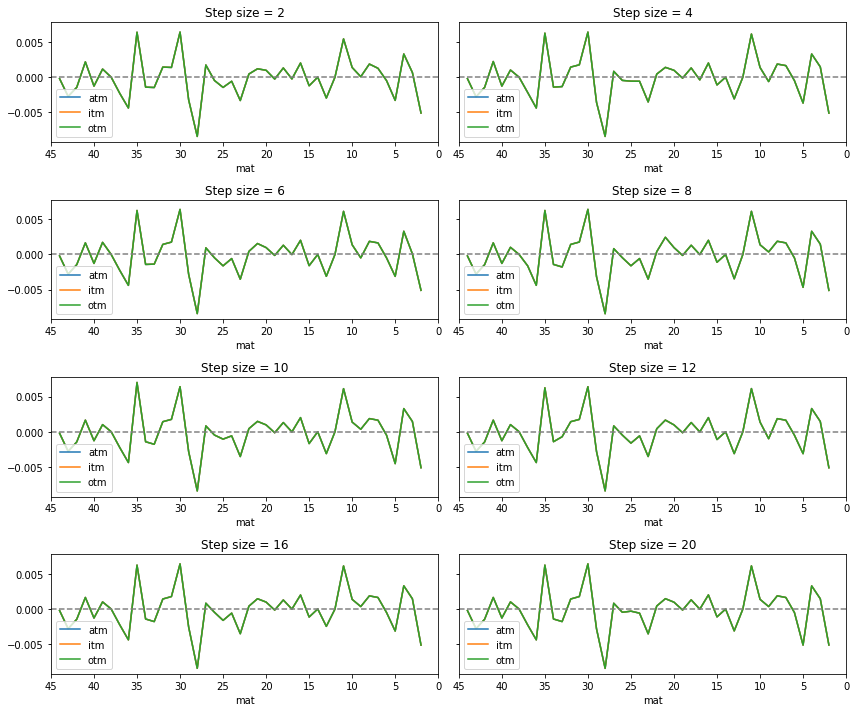

In [13]:
# Perform delta-vega hedging on Butterfly spread portfolio
# consisting of 1 itm, -2 atm and 1 otm option

# Keep these paramters fixed
hedge_freq = [2, 4, 6, 8, 10, 12, 16, 20]
num_sim = len(hedge_freq)
mat1 = 45

# Initalize matrices to store simulation results
MSE = np.zeros((num_sim, 3))
turnover_alpha = np.zeros((num_sim, 3))

turnover_eta_itm = np.zeros((num_sim, 3))
turnover_eta_atm = np.zeros((num_sim, 3))
turnover_eta_otm = np.zeros((num_sim, 3))

fig, axes = plt.subplots(math.ceil(num_sim / 2),2,figsize=(12,10), sharey=True)

for i, (ax, freq) in enumerate(zip(axes.flat, hedge_freq)):
    for j, (diff, label) in enumerate(zip(diffs,labels)):
        
        df = butterfly_delta_vega_simulation(sheet, E, step=freq, mat1=mat1)
        df.plot(y='A', ax=ax, label=label)
        
        MSE[i, j] = np.sqrt(df.A.pow(2).sum())
        turnover_alpha[i,j] = df.dAlpha.abs().sum()
        turnover_eta_itm[i,j] = df.dEta_itm.abs().sum()
        turnover_eta_atm[i,j] = df.dEta_atm.abs().sum()
        turnover_eta_otm[i,j] = df.dEta_otm.abs().sum()
        
    ax.axhline(y=0, linestyle='dashed', color='grey')
    ax.set_xlim([mat, 0]) 
    ax.set_title('Step size = {}'.format(freq))

fig.tight_layout()

# Calculate statistics for each rehedge frequency simulations

# MSE denotes means-squared-error of A values
# turnover_alpha denotes the turnover of underlying
# turnover_eta_itm denotes the turnover of itm option (longer maturity)
# turnover_eta_atm denotes the turnover of atm option (longer maturity)
# turnover_eta_otm denotes the turnover of otm option (longer maturity)

MSE_df = pd.DataFrame(MSE, columns = ["MSE_{}".format(label) for label in labels])
MSE_df.insert(0, 'Freq', hedge_freq)

turnover_alpha_df = pd.DataFrame(turnover_alpha,  columns=["t_alpha_{}".format(label) for label in labels])

turnover_eta_itm_df = pd.DataFrame(
    turnover_eta_itm,  columns=["t_eta_itm_{}".format(label) for label in labels])

turnover_eta_atm_df = pd.DataFrame(
    turnover_eta_atm,  columns=["t_eta_atm_{}".format(label) for label in labels])

turnover_eta_otm_df = pd.DataFrame(
    turnover_eta_otm,  columns=["t_eta_otm_{}".format(label) for label in labels])

stats = pd.concat([MSE_df,
                   turnover_alpha_df,
                   turnover_eta_itm_df,
                   turnover_eta_atm_df,
                   turnover_eta_otm_df], axis=1)

#stats['costs'] = stats.Turnover* 1e5*5e-4

display(stats)